In [1]:
import numpy as np
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

import re

# COVID-19 Research Paper K-Means Clustering

- Read in the metadata csv, select only the papers with full texts available.
- Split the df into four dfs according to the license type, so its easier to find the corresponding full text file
- Drops rows where the "sha" corresponds to more than one full text file


In [15]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]
#df_abstracts

In [16]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial

,sha,abstract
42763,a1cdea1502a0fd90dbbff6e8a29480d856c03fed,BACKGROUND: Neonatal diarrhea accounts for mor...
1911,a4f0b6baa85871705a0cfa6eaaad43d4e8316108,Abstract This chapter synthesizes current know...
40815,8003a720b0a0e15fc535a39d7ae6d7a444a2cb4c,Abstract We evaluated the safety and immunogen...
12423,3928a133e136a1a11b7d97a047b3aa8500e289b0,NaN
6775,9c940298ee86fe96bd26a793b6498755794cd254,Abstract Accumulating evidence indicates that ...
...,...,...
17390,99a3774ff408724afcda0708fc3c3223c0c74c6a,Small interfering RNAs (siRNAs) are potent mol...
7870,8ad16be256f6ab318d6c84b1d74159a4831a5b8a,NaN
27014,76bbd67d210cfbd619123b103b0aa1966857b75a,The People’s Republic of China has nearly the ...
3121,8348bc04a0ea6bd76d02f992a139ad4869d1f659,"Abstract Food security, sustainable agricultur..."


In [17]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [18]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [19]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")
porterStemmer = PorterStemmer()

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [20]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 100, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [21]:
"""100 most relevant features"""

(df.columns)

Index(['abstract', 'activ', 'acut', 'analysi', 'anim', 'antibodi', 'assay',
       'associ', 'c', 'case', 'caus', 'cell', 'clinic', 'compar', 'conclus',
       'control', 'coronavirus', 'cov', 'data', 'day', 'demonstr', 'detect',
       'develop', 'differ', 'diseas', 'dure', 'effect', 'emerg', 'express',
       'factor', 'function', 'gene', 'genom', 'group', 'health', 'high',
       'hospit', 'host', 'howev', 'human', 'identifi', 'immun', 'import',
       'includ', 'increas', 'indic', 'induc', 'infect', 'infecti', 'influenza',
       'investig', 'isol', 'level', 'method', 'model', 'n', 'new', 'number',
       'observ', 'outbreak', 'p', 'pathogen', 'patient', 'pcr', 'posit',
       'potenti', 'present', 'protein', 'provid', 'rate', 'relat', 'replic',
       'report', 'respiratori', 'respons', 'result', 'risk', 'rna', 'role',
       's', 'sampl', 'sequenc', 'sever', 'signific', 'specif', 'strain',
       'structur', 'studi', 'suggest', 'target', 'test', 'time', 'transmiss',
       'treat

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


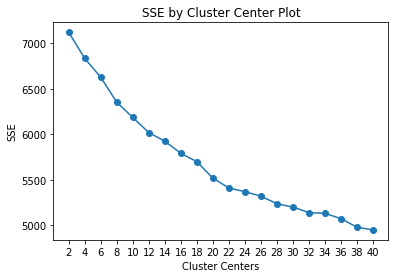

In [22]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(df, 40)

In [10]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
#dd